In [2]:
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset as BaseDataset
import torch.cuda as cuda
import torch
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from enum import Enum
import cv2 
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from torch.optim import lr_scheduler


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if not torch.cuda.is_available():
    raise RuntimeError("CUDA is not available. Please ensure you have a compatible GPU and CUDA installed.")

class Cls(Enum):
    UPRIGHT = (0, "#b7f2a6")  # light green
    FALLEN = (1, "#c71933")   # red
    OTHER = (2, "#ffcc33")    # yellow

    def __new__(cls, num, hex_color):
        obj = object.__new__(cls)
        obj._value_ = num
        obj.hex_color = hex_color
        obj.rgb_color = tuple(int(hex_color[i:i+2], 16) for i in (1, 3, 5))  # Convert hex to RGB
        return obj
    


SEED = 42

base_path = os.path.join('..', 'dataset_processed')
images_path = os.path.join(base_path, 'images')
masks_path = os.path.join(base_path, 'masks')
splits_path = os.path.join(base_path, 'splits')

torch.set_float32_matmul_precision('medium') # TODO see if high is better or low doesn't make a difference

c:\Users\dbutt7\AppData\Local\miniconda3\envs\torch-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataloader
Writing helper class for data extraction, tranformation and preprocessing

In [3]:

def resplit(dataset_path, train_frac=0.7, val_frac=0.2, test_frac=0.1, seed=SEED):
    assert train_frac + val_frac + test_frac == 1.0, "Fractions must sum to 1."

    scenes = sorted(os.listdir(os.path.join(dataset_path, 'images')))
    random.seed(seed)
    random.shuffle(scenes)
    
    n = len(scenes)
    n_train = int(n * train_frac)
    # Use remaining scenes for both validation and test equally
    remaining = n - n_train
    half = remaining // 2  # ensure both splits have the same number of scenes
    
    train_scenes = scenes[:n_train]
    val_scenes = scenes[n_train:n_train+half]
    test_scenes = scenes[n_train+half:n_train+2*half]

    os.makedirs(os.path.join(dataset_path, 'splits'), exist_ok=True)
    for name, split in zip(['train', 'val', 'test'], [train_scenes, val_scenes, test_scenes]):
        with open(os.path.join(dataset_path, 'splits', f'{name}.txt'), 'w') as f:
            for scene in split:
                f.write(f"{scene}\n")

class Dataset(BaseDataset):

    
    def __init__(self, image_root, mask_root, split_file, transform=None):
        self.background_class = Cls.UPRIGHT.value
        assert os.path.exists(image_root), f"Image root {image_root} does not exist."
        assert os.path.exists(mask_root), f"Mask root {mask_root} does not exist."
        assert os.path.exists(split_file), f"Split file {split_file} does not exist."
        
        self.image_root = image_root
        self.mask_root = mask_root
        self.transform = transform
        
        with open(split_file, 'r') as f:
            self.scenes = [line.strip() for line in f if line.strip()]
        
        self.samples = []
        for scene in self.scenes:
            image_dir = os.path.join(self.image_root, scene)
            mask_dir = os.path.join(self.mask_root, scene)
            
            for fname in sorted(os.listdir(image_dir)):
                if not fname.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.tif')):
                    continue
                img_path = os.path.join(image_dir, fname)
                name, ext = os.path.splitext(fname)
                mask_path = os.path.join(mask_dir, f"{name}_mask{ext}")  
                self.samples.append((img_path, mask_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]
        image = np.array(Image.open(img_path).convert('RGB'))
        mask = np.array(Image.open(mask_path))
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]
        return image, mask

def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split("_")).title())

        # If it's an image, plot it as RGB
        if name == "image":
            # Convert CHW to HWC for plotting
            image = image.transpose(1, 2, 0)
            plt.imshow(image)
        else:
            plt.imshow(image, cmap="tab20")
    plt.show()



In [4]:
def get_training_augmentation():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=20, val_shift_limit=15, p=0.3),
        
        A.OneOf([
            A.GaussianBlur(blur_limit=3, p=0.3),
            A.MotionBlur(blur_limit=3, p=0.3),
            A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.3),
        ], p=0.3),
        
        A.GaussNoise(p=0.2),
        
        A.OneOf([
            A.ElasticTransform(alpha=1, sigma=50, p=0.3, border_mode=cv2.BORDER_CONSTANT, mask_value=Cls.OTHER.value), 
            A.GridDistortion(num_steps=5, distort_limit=(-0.1, 0.1), p=0.3, border_mode=cv2.BORDER_CONSTANT, mask_value=Cls.OTHER.value),
        ], p=0.2),
        
        A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.05, rotate_limit=0, 
                          p=0.3, border_mode=cv2.BORDER_CONSTANT, mask_value=Cls.OTHER.value),

        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

In [5]:
resplit(base_path, train_frac=0.7, val_frac=0.15, test_frac=0.15)

dataset_train = Dataset(
    image_root=images_path,
    mask_root=masks_path,
    split_file=os.path.join(splits_path, 'train.txt'),
    transform=get_training_augmentation()  
)

dataset_val = Dataset(
    image_root=images_path,
    mask_root=masks_path,
    split_file=os.path.join(splits_path, 'val.txt'),
    transform=None  
)

dataset_test = Dataset(
    image_root=images_path,
    mask_root=masks_path,
    split_file=os.path.join(splits_path, 'test.txt'),
    transform=None  
)


c:\Users\dbutt7\AppData\Local\miniconda3\envs\torch-env\lib\site-packages\albumentations\augmentations\blur\transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


Showing image 2021 of 3768
Mask shape: torch.Size([512, 512])
Image shape: torch.Size([3, 512, 512])


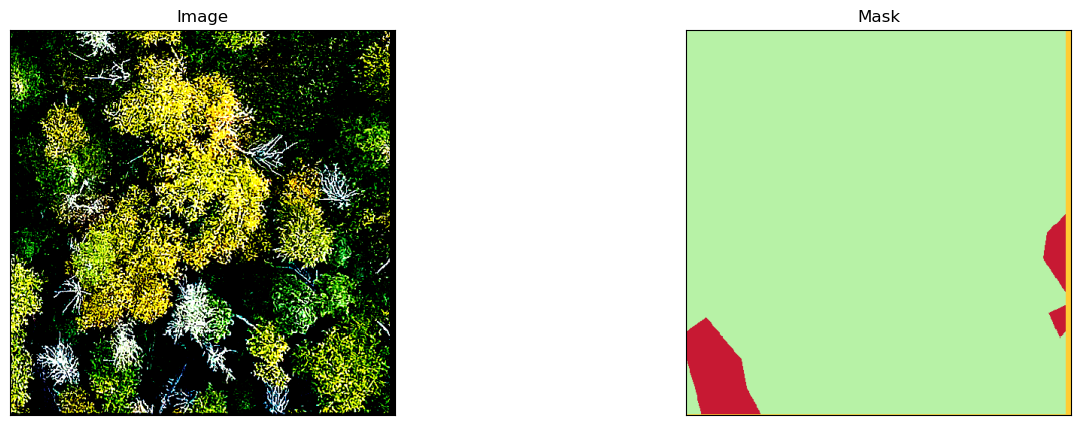

In [11]:
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, img) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split("_")).title())
        if name == "image":
            # Check if image is in CHW format; if so, convert it to HWC for plotting
            if img.shape[0] == 3:
                try:
                    # If image is a torch tensor, use permute
                    if isinstance(img, torch.Tensor):
                        img = img.permute(1, 2, 0).cpu().numpy()
                    else:
                        img = img.transpose(1, 2, 0)
                except Exception:
                    pass
            plt.imshow(img)
        else:
            # Convert greyscale integer mask to RGB colored mask using the enum mapping
            # Build a lookup table from enum values (0,1,2) to the corresponding RGB colors.
            lut = np.array([
                Cls.UPRIGHT.rgb_color,
                Cls.FALLEN.rgb_color,
                Cls.OTHER.rgb_color
            ], dtype=np.uint8)
            # Map the greyscale mask to an RGB image by indexing using the mask values.
            color_mask = lut[img]
            plt.imshow(color_mask)
    plt.show()

idx = random.randint(0, len(dataset_train) - 1)
image, mask = dataset_train[idx] 
print(f"Showing image {idx} of {len(dataset_train)}")
print(f"Mask shape: {mask.shape}")
print(f"Image shape: {image.shape}")
visualize(image=image, mask=mask)

# Create model and train

In [ ]:
# Some training hyperparameters TODO tune
EPOCHS = 50
BATCH_SIZE = 4 
T_MAX = EPOCHS * len(dataset_train)
OUT_CLASSES = len(Cls)

class CamVidModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )

        # Preprocessing parameters for image normalization
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.number_of_classes = out_classes
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1).to(device))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1).to(device))

        # Loss function for multi-class segmentation
        self.loss_fn = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)

        # Step metrics tracking
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # Normalize image
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image, mask = batch

        # Move tensors to device
        image = image.to(device)
        mask = mask.to(device)

        # Ensure that image dimensions are correct
        assert image.ndim == 4  # [batch_size, channels, H, W]

        # Ensure the mask is a long (index) tensor
        mask = mask.long()

        # Mask shape
        assert mask.ndim == 3  # [batch_size, H, W]

        # Predict mask logits
        logits_mask = self.forward(image)

        assert (
            logits_mask.shape[1] == self.number_of_classes
        )  # [batch_size, number_of_classes, H, W]

        # Ensure the logits mask is contiguous
        logits_mask = logits_mask.contiguous()

        # Compute loss using multi-class Dice loss (pass original mask, not one-hot encoded)
        loss = self.loss_fn(logits_mask, mask)

        # Apply softmax to get probabilities for multi-class segmentation
        prob_mask = logits_mask.softmax(dim=1)

        # Convert probabilities to predicted class labels
        pred_mask = prob_mask.argmax(dim=1)

        # Compute true positives, false positives, false negatives, and true negatives
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask, mask, mode="multiclass", num_classes=self.number_of_classes
        )

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # Aggregate step metrics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # Per-image IoU and dataset IoU calculations
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        self.training_step_outputs.clear()

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }

# Use SegFormer-B2 pretrained on ADE20K by setting encoder_name to "mit_b2"
# and passing encoder_weights="ade20k".
model = CamVidModel("SegFormer", "mit_b0", in_channels=3, out_classes=OUT_CLASSES, encoder_weights="imagenet").to(device)

train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, persistent_workers=True) # Adjust num_workers as needed
val_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, persistent_workers=True) # Adjust num_workers as needed

trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1, fast_dev_run=True) # fast_dev_run=True will run only 1 batch for train and val

trainer.fit(
    model,
    train_dataloaders=train_loader, # Pass the DataLoader
    val_dataloaders=val_loader,     # Pass the DataLoader
)

# Validation and test metrics

In [ ]:
# # run validation dataset
# valid_metrics = trainer.validate(model, dataloaders=valid_loader, verbose=False)
# print(valid_metrics)

In [ ]:
# # run test dataset
# test_metrics = trainer.test(model, dataloaders=test_loader, verbose=False)
# print(test_metrics)

# Result visualization

In [ ]:
# import numpy as np

# # Fetch a batch from the test loader
# images, masks = next(iter(test_loader))

# # Switch the model to evaluation mode
# with torch.no_grad():
#     model.eval()
#     logits = model(images)  # Get raw logits from the model

# # Apply softmax to get class probabilities
# # Shape: [batch_size, num_classes, H, W]

# pr_masks = logits.softmax(dim=1)
# # Convert class probabilities to predicted class labels
# pr_masks = pr_masks.argmax(dim=1)  # Shape: [batch_size, H, W]

# # Visualize a few samples (image, ground truth mask, and predicted mask)
# for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
#     if idx <= 4:  # Visualize first 5 samples
#         plt.figure(figsize=(12, 6))

#         # Original Image
#         plt.subplot(1, 3, 1)
#         plt.imshow(
#             image.cpu().numpy().transpose(1, 2, 0)
#         )  # Convert CHW to HWC for plotting
#         plt.title("Image")
#         plt.axis("off")

#         # Ground Truth Mask
#         plt.subplot(1, 3, 2)
#         plt.imshow(gt_mask.cpu().numpy(), cmap="tab20")  # Visualize ground truth mask
#         plt.title("Ground truth")
#         plt.axis("off")

#         # Predicted Mask
#         plt.subplot(1, 3, 3)
#         plt.imshow(pr_mask.cpu().numpy(), cmap="tab20")  # Visualize predicted mask
#         plt.title("Prediction")
#         plt.axis("off")

#         # Show the figure
#         plt.show()
#     else:
#         break